In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [52]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [53]:
tr = pd.read_csv('train.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})
ev = pd.read_csv('evaluation.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})
test = pd.read_csv('test.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})

dataset = pd.concat([tr, ev, test], axis=0, ignore_index=True)

In [54]:
print('Nombre de las columnas:\n', dataset.columns)
print('\nDimensiones de los datos: ', dataset.shape)
print('\nValores ausentes:\n', dataset.isnull().sum())

Nombre de las columnas:
 Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

Dimensiones de los datos:  (40587, 4)

Valores ausentes:
 Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


La columna Unnamed: 0 contiene la posición en la base de datos de cada muestra. No es relevante para el estudio y se va a eliminar de la base de datos.

In [55]:
dataset = dataset.drop(columns=['Unnamed: 0'])
print(dataset.shape)

(40587, 3)


# Análisis exploratorio

## Análisis de la característica title

In [56]:
freq = dataset.value_counts('title')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de title"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de title
0            1                       39605
1            2                         375
2            3                           9
3            4                           2
4           14                           1
5          153                           1
6            5                           1
7            6                           1
8            8                           1
9           11                           1


Como podemos ver la mayoría de titulares de noticia son únicos, es decir, que aparecen una única vez. Los titulares con más de una aparición puede que se deba a que se hayan cogido diferentes fragmentos de una noticia como muestras distintas, pero el titular se comparte entre ellas. En caso de que no fuera así y hubiera muestras repetidas lo podríamos comprobar cuando analicemos la característica text. Si comparte las mismas apariciones que esta característica significará que hay muestras repetidas y las eliminaremos de la base de datos.

## Análisis de la característica text

In [57]:
freq = dataset.value_counts('text')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de text"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de text
0            1                      40583
1            2                          2


Podemos ver que solo hay dos pares de muestras repetidas lo que confirma nuestra teoría para la característica title. Por lo tanto, únicamente tenemos que eliminar una de las muestras de cada par duplicado.

In [58]:
dataset = dataset.drop_duplicates(subset='text', keep='first')

In [59]:
freq = dataset.value_counts('text')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de text"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de text
0            1                      40585


In [60]:
num_palabras = dataset['text'].apply(lambda x: len(str(x).split()))
media_palabras = num_palabras.mean()

min_palabras = num_palabras.min()
max_palabras = num_palabras.max()

cantidad_50_o_menos = (num_palabras <= 50).sum()

print("Media de palabras:", media_palabras)
print("Mínimo número de palabras:", min_palabras)
print("Máximo número de palabras:", max_palabras)
print("Número de muestras con 50 palabras o menos:", cantidad_50_o_menos)

Media de palabras: 407.95843291856596
Mínimo número de palabras: 0
Máximo número de palabras: 8135
Número de muestras con 50 palabras o menos: 1527


Q1: 211.0
Q2 (mediana): 367.0
Q3: 514.0
Media: 407.95843291856596


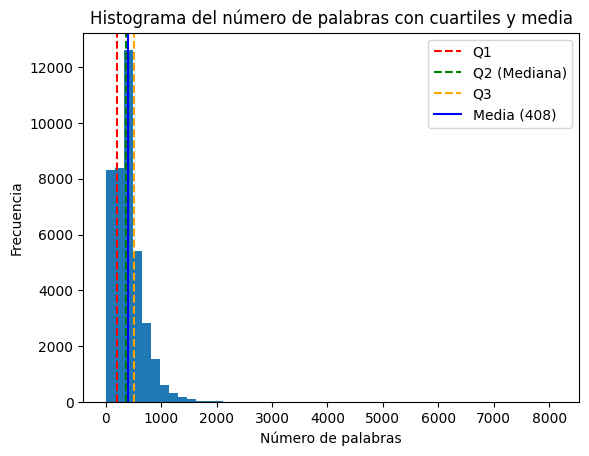

In [61]:
q1 = num_palabras.quantile(0.25)
q2 = num_palabras.quantile(0.50)   # mediana
q3 = num_palabras.quantile(0.75)

print("Q1:", q1)
print("Q2 (mediana):", q2)
print("Q3:", q3)
print("Media:", num_palabras.mean())  # debería ser 408

plt.hist(num_palabras, bins=50)
plt.axvline(q1, color='red', linestyle='--', label='Q1')
plt.axvline(q2, color='green', linestyle='--', label='Q2 (Mediana)')
plt.axvline(q3, color='orange', linestyle='--', label='Q3')
plt.axvline(408, color='blue', linestyle='-', label='Media (408)')

plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma del número de palabras con cuartiles y media')
plt.legend()
plt.show()


Quitamos las muestras con menos de 50 palabras al no ser suficientemente largo para el modelo, además de recortar los textos que son muy largos con un máximo de 1000 palabras

In [62]:
dataset = dataset[num_palabras >= 100].reset_index(drop=True)
print(dataset.shape)


def recortar_texto(texto, limite=1000):
    palabras = str(texto).split()
    if len(palabras) > limite:
        palabras = palabras[:limite]
    return " ".join(palabras)

dataset["text"] = dataset["text"].apply(recortar_texto)
num_palabras = dataset["text"].apply(lambda x: len(str(x).split()))
print("Máximo número de palabras ahora:", num_palabras.max())



(35241, 3)
Máximo número de palabras ahora: 1000


## Análisis de la característica label

In [63]:
freq = dataset.value_counts('label')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de label"]
print(dataset['label'].value_counts(normalize=True) * 100)
print(df_histograma_frecuencias)

label
1    51.607503
0    48.392497
Name: proportion, dtype: float64
   Apariciones  Número de valores de label
0        18187                           1
1        17054                           1


<Axes: >

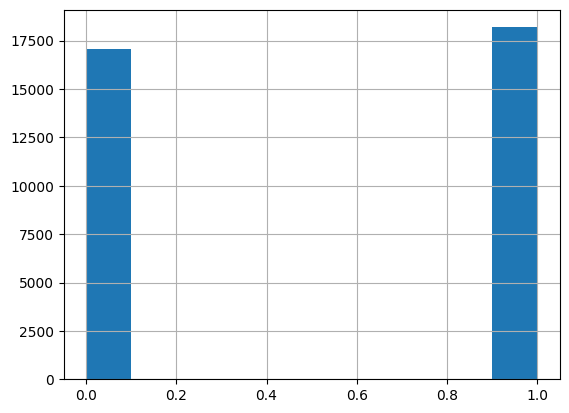

In [64]:
dataset['label'].hist()

Podemos ver que más o menos tenemos la misma cantidad de muestras con etiqueta 0 y 1, convirtiendo esta base de datos en adecuada para el entrenamiento de una red neuronal.

Separamos la base de datos en tres: entrenamiento, validación y test

In [65]:
dataset = dataset.drop(index=0).reset_index(drop=True)
train, temp = train_test_split(dataset, test_size=0.30, random_state=42)
val, test = train_test_split(temp, test_size=0.50, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)

# Separar características y etiquetas
X_train = train.drop(columns=['label'])
y_train = train['label']

X_val = val.drop(columns=['label'])
y_val = val['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Comprobar tamaños
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


(24668, 3)
(5286, 3)
(5286, 3)
X_train: (24668, 2) y_train: (24668,)
X_val: (5286, 2) y_val: (5286,)
X_test: (5286, 2) y_test: (5286,)


# Modelado de un algoritmo de clasificación

Hemos decidido utilizar el algoritmo X para comparar su desempeño con nuestra red nueronal

In [66]:
#Usamos solo la columna 'text' como entrada de texto
X_train_text = X_train["text"]
X_val_text = X_val["text"]
X_test_text = X_test["text"]

#Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [67]:
#Modelo de scikit-learn (RandomForest como decías)
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train_tfidf, y_train)

#Evaluación en validación y test
y_val_pred = clf.predict(X_val_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

print("=== Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("=== Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

=== Validación ===
Accuracy val: 0.9820279984865683
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2534
           1       0.99      0.97      0.98      2752

    accuracy                           0.98      5286
   macro avg       0.98      0.98      0.98      5286
weighted avg       0.98      0.98      0.98      5286

=== Test ===
Accuracy test: 0.9822171774498676
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2561
           1       0.99      0.97      0.98      2725

    accuracy                           0.98      5286
   macro avg       0.98      0.98      0.98      5286
weighted avg       0.98      0.98      0.98      5286

